In [1]:
import os, sys, glob

from BreyoSpec import BreyoSpec
import numpy as np
import matplotlib.pyplot as plt


In [178]:
# define some useful functions
def combSpec(spec1, spec2, radFrac=1, w=0.01):
    '''
    Combine spectrum and simulate noise
    
    spec1 and spec2 are BreyoSpec objects
    w [float] :  number between 0 and 1 defining how noisy the combined spectrum should be
    radFrac [float] : fraction of exoplanet radius to host star radius
    return: subtracted spectrum
    '''
    
    # determine factor to mulitply spec2.flux by
    fracAtm = 0.25 # define 10% of the exoplanets atmosphere as transmissible
    factor = (1-(1-fracAtm)**2)*(radFrac)**2
    
    # combine flux with that factor
    combFlux = spec1.flux + factor*spec2.flux # add spectra
    combFluxNoisy = combFlux+w*np.random.normal(combFlux) # simulate noise
    
    return spec1.wave, combFluxNoisy

def plotExo(exowave, exoflux, jupwave, jupflux, ax=None, **kwargs):
    
    if not ax:
        fig, ax = plt.subplots(figsize=(16,6))
    
    ax.plot(exowave, exoflux, **kwargs)
    ax.plot(jupwave, jupflux-np.median(jupflux), label='Jupiter')
    ax.axvline( 6562.8, color='k', linestyle='--', label=r'H$\alpha$', alpha=0.5)
    ax.axvline( 4861.3, color='k', linestyle='--', label=r'H$\beta$', alpha=0.5)
    ax.axvline( 4340.4, color='k', linestyle='--', label=r'H$\gamma$', alpha=0.5)
    ax.axvline( 6190, color='r', linestyle='--', label=r'Methane', alpha=0.5)

    ax.set_xlabel('Wavelength [$\AA$]', fontsize=16)
    ax.set_ylabel('Flux [$e^-$]', fontsize=16)
    ax.grid()

In [179]:
hostDir = '/home/ubuntu/Documents/ObsAstro/Data/postTransitOutput/'
hostPaths = glob.glob(hostDir+"*")

jupPath = '/home/ubuntu/Documents/ObsAstro/Data/Jupiter_20211109T005343.fit'

In [180]:
hostSpec = BreyoSpec(hostPaths) # host star spectrum
jupSpec = BreyoSpec(jupPath)

In [181]:
from specutils.analysis import snr
from specutils import Spectrum1D
from astropy import units as u
from astropy.nddata import NDUncertainty

plot = False
n = 1000

radiusFrac = np.linspace(0,1,n)
percents = []
snrs = []

for rf in radiusFrac:
    wave, flux = combSpec(hostSpec, jupSpec, radFrac=rf)
    
    exoFlux = flux - hostSpec.flux
    
    if plot:
        fig, ax = plt.subplots(figsize=(16,6))
        plotExo(wave, exoFlux, jupSpec.wave, jupSpec.flux, ax=ax, label='Exoplanet Spectrum')
        ax.legend()
        ax.set_title(f'R_p/R_star = {rf}')
        ax.axhline(np.median(exoFlux), color='k')
    
    methaneWave = 6190
    whereMethane = np.where((wave > methaneWave-10) * (wave < methaneWave+10))[0]
    
    noise = np.median(exoFlux)
    methaneMed = np.median(exoFlux[whereMethane])
    
    percentAboveNoise = np.abs((noise - methaneMed))
    percents.append(percentAboveNoise)

Text(0, 0.5, 'Median(Flux) - Methane Flux')

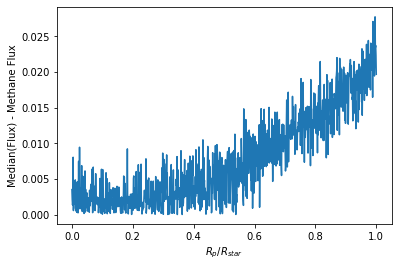

In [183]:
plt.plot(radiusFrac, percents)
plt.xlabel('$R_p / R_{star}$')
plt.ylabel('Median(Flux) - Methane Flux')